## ARIMA

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [32]:
df = pd.read_csv("data/Electric_Production.csv", parse_dates=['DATE'], index_col='DATE')

- parse_dates tells pandas to parse this data as datetime objects
- index_col sets DATE as the index (makes slicing easier)

In [33]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


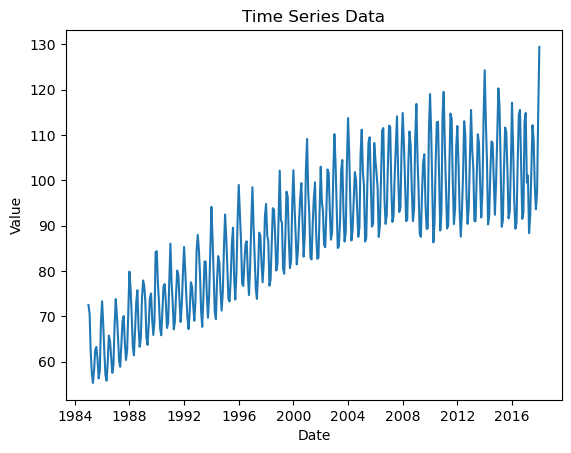

In [34]:
# See an overall pattern - can make this interactive with seaborn or shiny with R
plt.plot(df)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

### Checking for stationarity
- Checking for stationarity (ARIMA needs it) using ADF/KPSS test, if not we can use differencing/transformation

In [35]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['IPG2211A2N'])
print('ADF Statistic:', result[0])
print("Significance Value:", 0.05)
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Since p-value>significance value, this data is non-stationary

ADF Statistic: -2.25699035004723
Significance Value: 0.05
p-value: 0.18621469116587275
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


- Applying first order differencing and re-calculating

In [36]:
df['IPG2211A2N_FOD'] = df['IPG2211A2N'].diff()

In [37]:
df.head()

,IPG2211A2N,IPG2211A2N_FOD
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563


In [38]:
df.drop(index=df.index[0], axis=0, inplace=True)

In [39]:
df.head()

,IPG2211A2N,IPG2211A2N_FOD
DATE,,
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563
1985-06-01,58.0904,2.7753


In [40]:
result = adfuller(df['IPG2211A2N_FOD'])
print('ADF Statistic:', result[0])
print("Significance Value:", 0.05)
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#Since p-value<significance value, this data is stationary (means are more or less the same)

ADF Statistic: -7.104890882267299
Significance Value: 0.05
p-value: 4.0777865655397073e-10
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


### Building ARIMA model
- 3 parameters for ARIMA: 𝑝 (order of the autoregressive part), d (degree of first differencing involved), and 𝑞 (order of the moving average part).

D:\Anaconda\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


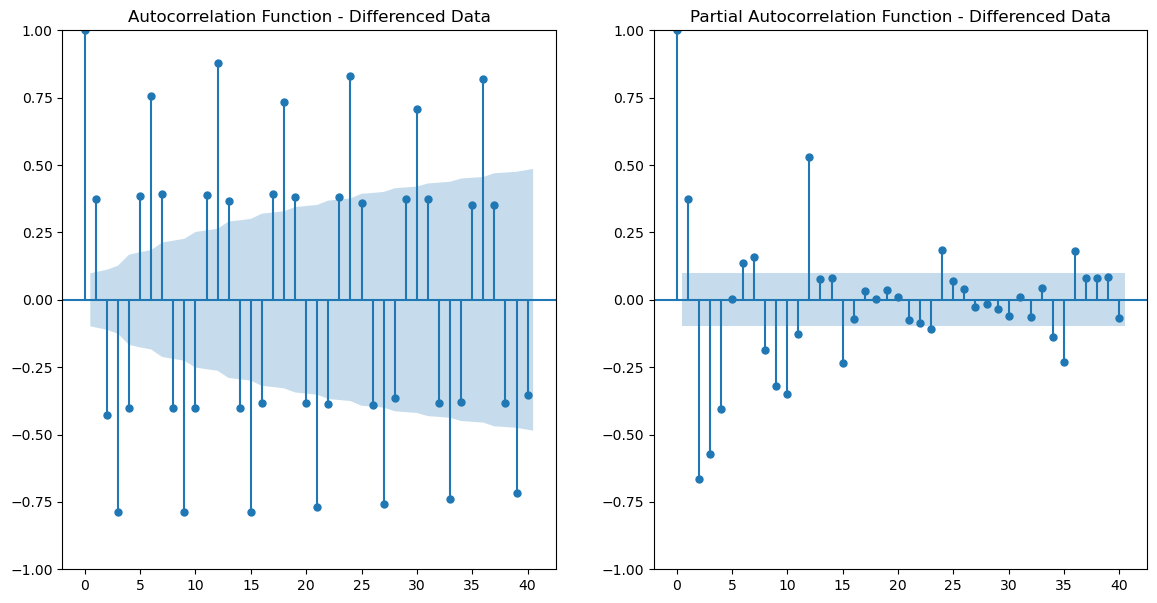

In [41]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plotting (to determine q)
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(df['IPG2211A2N_FOD'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function - Differenced Data')

# PACF plotting (to determine p)
plt.subplot(122)
plot_pacf(df['IPG2211A2N_FOD'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function - Differenced Data')

plt.show()

In [58]:
p = 2 #based on TNE cutoff mark in PACF (first point to go beyond shaded region)
d = 0 #0 since ACF, PACF were determined on the FOD column, if not this will be 1
q = 2 #based on TNE cutoff mark in ACF (first point to go beyond shaded region)

model = ARIMA(df['IPG2211A2N_FOD'], order=(p, d, q))
fitted_model = model.fit()

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Important intepretations

- Goodness of fit: Log likelihood measures how well the model fits the data and how well the parameters explain the observed data. Negative values are expected in most cases, dont worry about it!
- Residuals: Ljung-Box is expected to be above significant level of 0.05 for a good fit.

In [59]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:         IPG2211A2N_FOD   No. Observations:                  396
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1046.073
Date:                Sun, 02 Jun 2024   AIC                           2104.146
Time:                        11:19:46   BIC                           2128.035
Sample:                    02-01-1985   HQIC                          2113.610
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1305      0.166      0.788      0.431      -0.194       0.455
ar.L1          0.9999      0.002    537.463      0.000       0.996       1.004
ar.L2         -0.9994      0.001   -887.414      0.0

### Important intepretations

- Normal QQ Plot: if the data is placed close to the 45 degree lie, it means the data is normally distributed.
- Can use the histogram to understand the same.

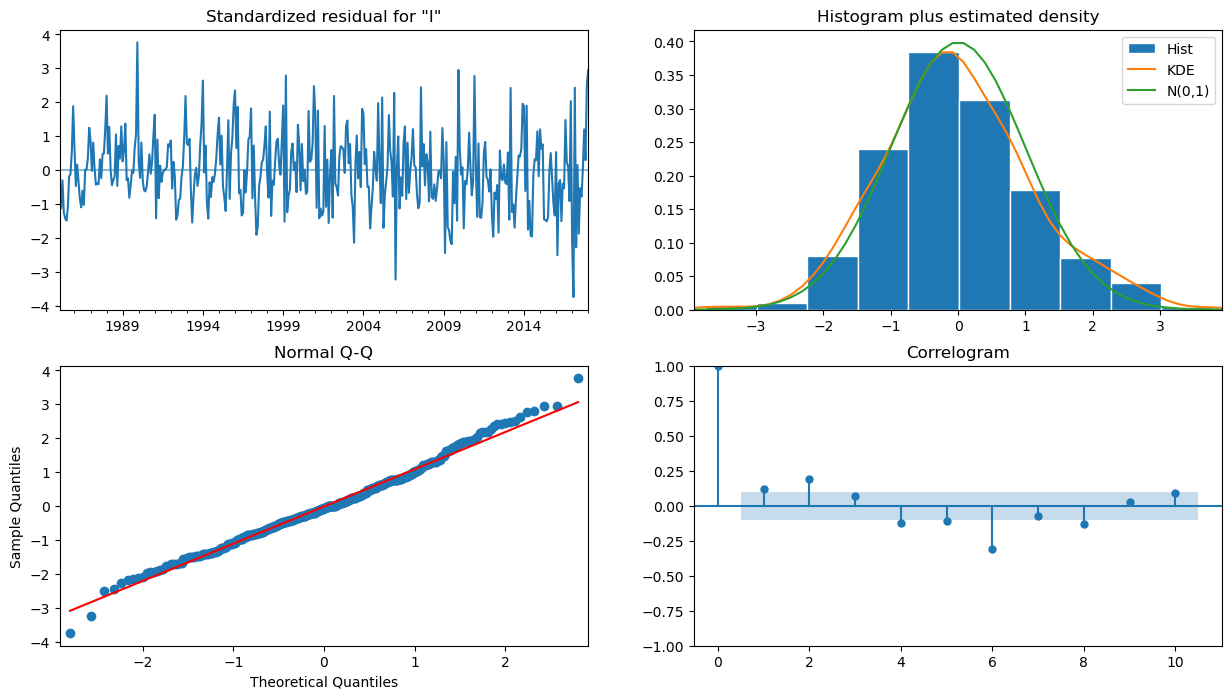

In [44]:
fitted_model.plot_diagnostics(figsize=(15, 8))
plt.show()

### Making predictions and back transforming to retrieve values prior to first-order differencing

In [45]:
forecast_results = fitted_model.get_forecast(steps=15)
forecast_values = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

In [46]:
print(forecast_values)

2018-02-01   -11.047272
2018-03-01   -16.361002
2018-04-01    -8.894476
2018-05-01     4.618002
2018-06-01    12.322398
2018-07-01     9.043825
2018-08-01    -4.332380
2018-09-01   -12.158504
2018-10-01    -8.764441
2018-11-01     4.494882
2018-12-01    12.424351
2019-01-01     8.932226
2019-02-01    -4.226741
2019-03-01   -12.243890
2019-04-01    -8.668555
Freq: MS, Name: predicted_mean, dtype: float64


In [47]:
last_value = df['IPG2211A2N'].iloc[-1]
forecast_levels = np.cumsum(forecast_values) + last_value

print("Forecasted values:\n", forecast_levels)

Forecasted values:
 2018-02-01    118.357528
2018-03-01    101.996527
2018-04-01     93.102050
2018-05-01     97.720052
2018-06-01    110.042450
2018-07-01    119.086275
2018-08-01    114.753895
2018-09-01    102.595391
2018-10-01     93.830950
2018-11-01     98.325832
2018-12-01    110.750183
2019-01-01    119.682409
2019-02-01    115.455668
2019-03-01    103.211778
2019-04-01     94.543223
Freq: MS, Name: predicted_mean, dtype: float64


### Plot forecasting

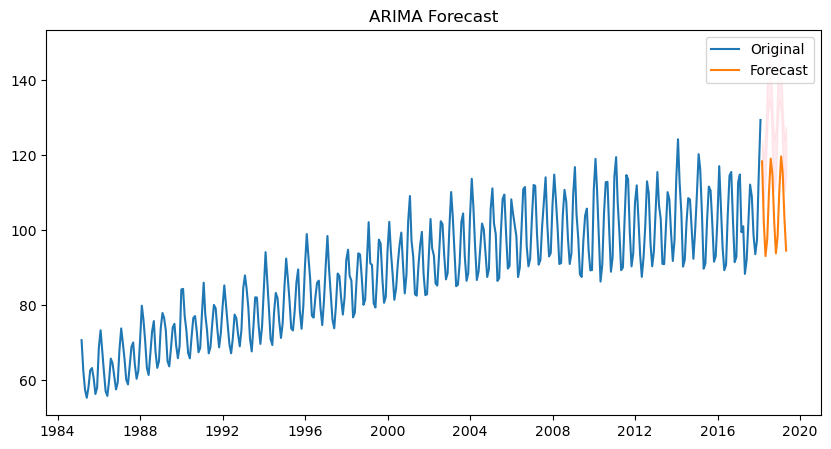

In [48]:
plt.figure(figsize=(10, 5))
original_index = pd.date_range(start=df.index[0], periods=len(df), freq='M')
forecast_index = pd.date_range(start=original_index[-1], periods=len(forecast_levels)+1, freq='M')[1:]
plt.plot(original_index, df['IPG2211A2N'], label='Original')
plt.plot(forecast_index, forecast_levels, label='Forecast')

plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0] + last_value, 
                 conf_int.iloc[:, 1] + last_value, 
                 color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

## EXTRA: Attempting with trial and error

In [28]:
p_list = [2,3,4,5]
d = 0 
q_list = [2,3,4,5]

In [29]:
def plot_predictions(forecast_levels, conf_int):
    plt.figure(figsize=(10, 5))
    original_index = pd.date_range(start=df.index[0], periods=len(df), freq='M')
    forecast_index = pd.date_range(start=original_index[-1], periods=len(forecast_levels)+1, freq='M')[1:]
    plt.plot(original_index, df['IPG2211A2N'], label='Original')
    plt.plot(forecast_index, forecast_levels, label='Forecast')

    plt.fill_between(forecast_index, 
                     conf_int.iloc[:, 0] + last_value, 
                     conf_int.iloc[:, 1] + last_value, 
                     color='pink', alpha=0.3)
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()

P value: 2
Q value: 2


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


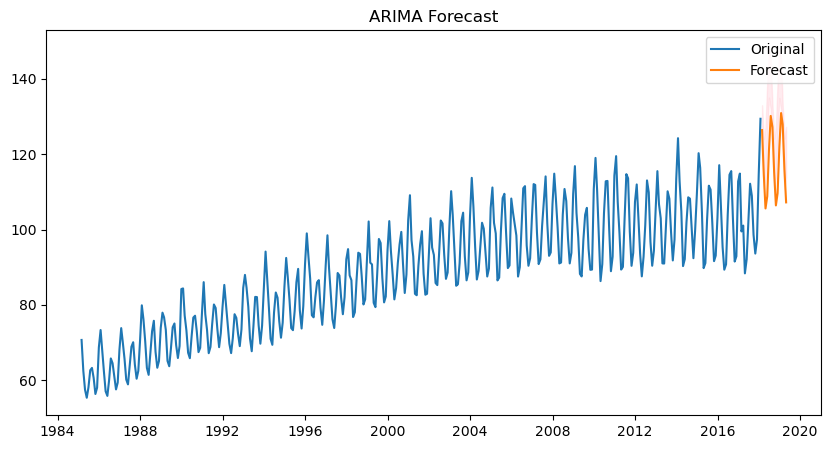

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 2
Q value: 3


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


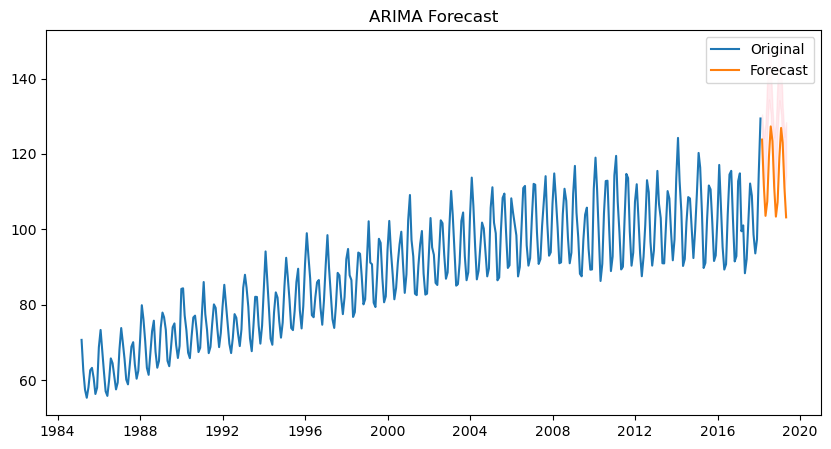

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 2
Q value: 4


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


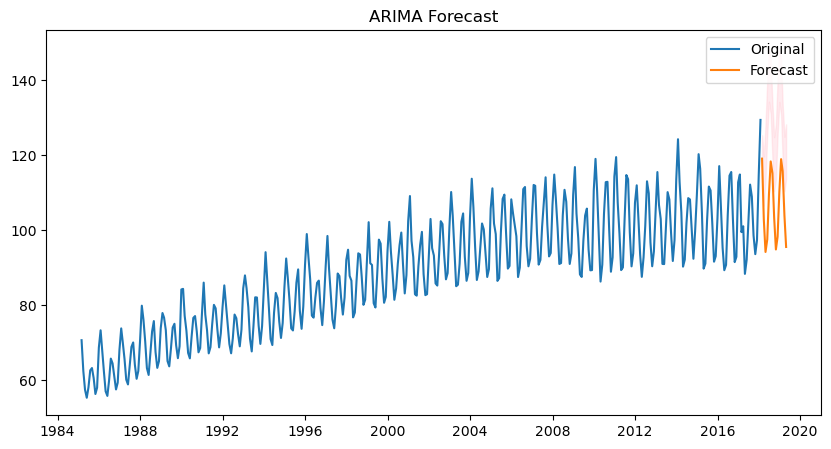

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 2
Q value: 5


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


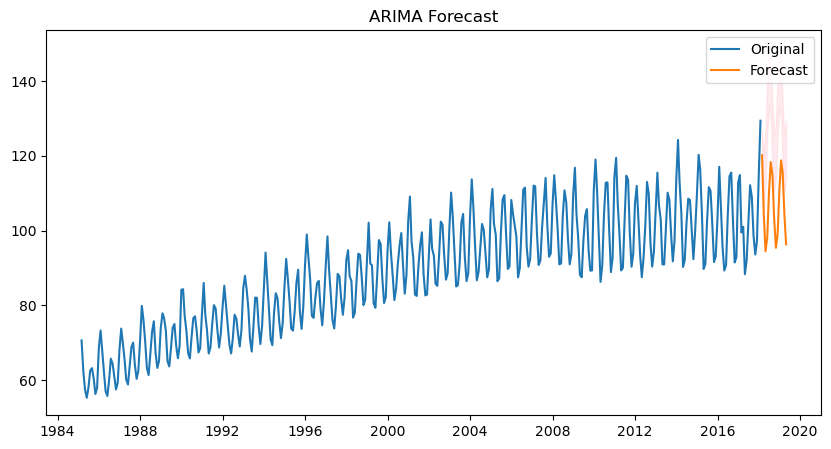

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 3
Q value: 2


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


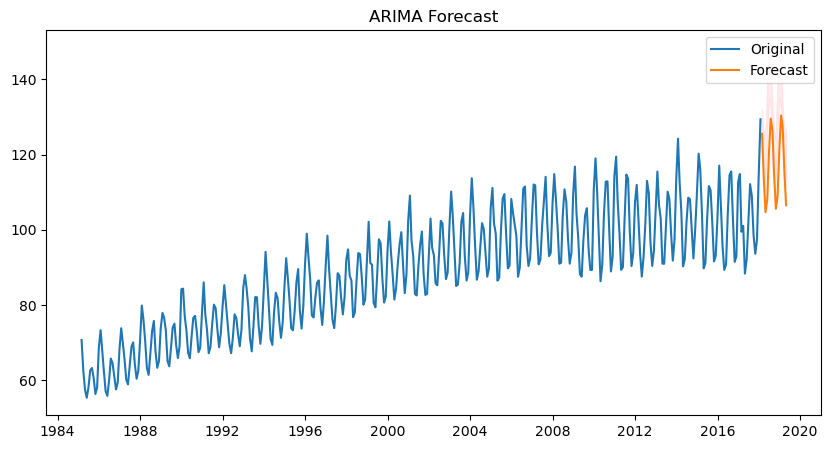

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 3
Q value: 3


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


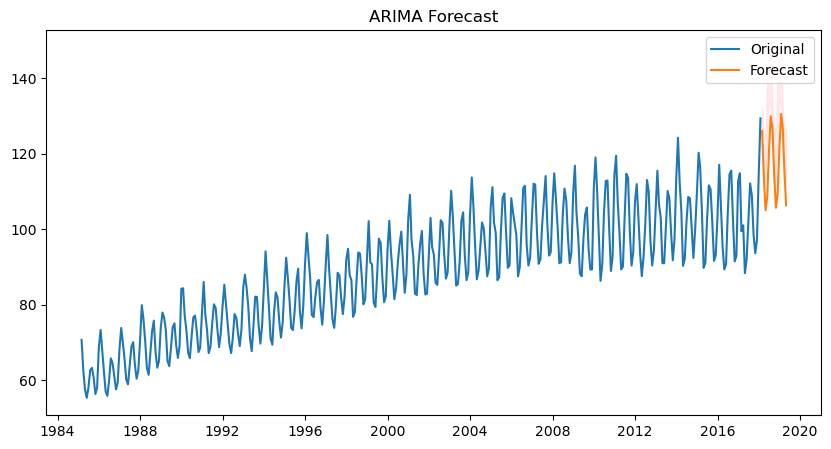

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 3
Q value: 4


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


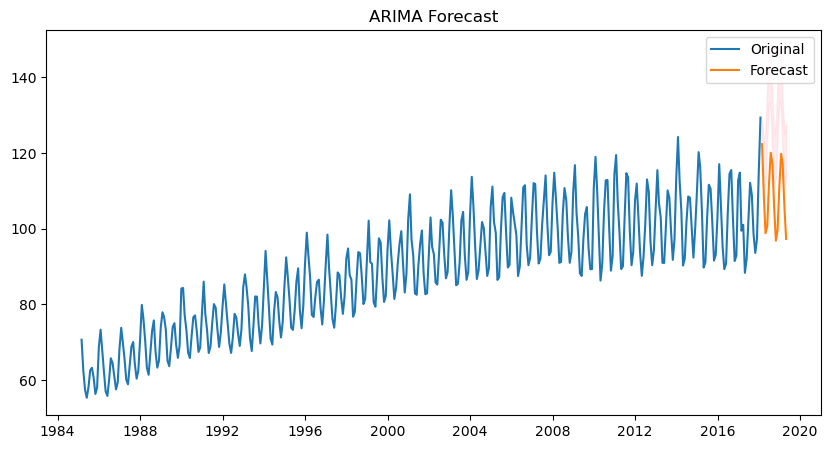

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 3
Q value: 5


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


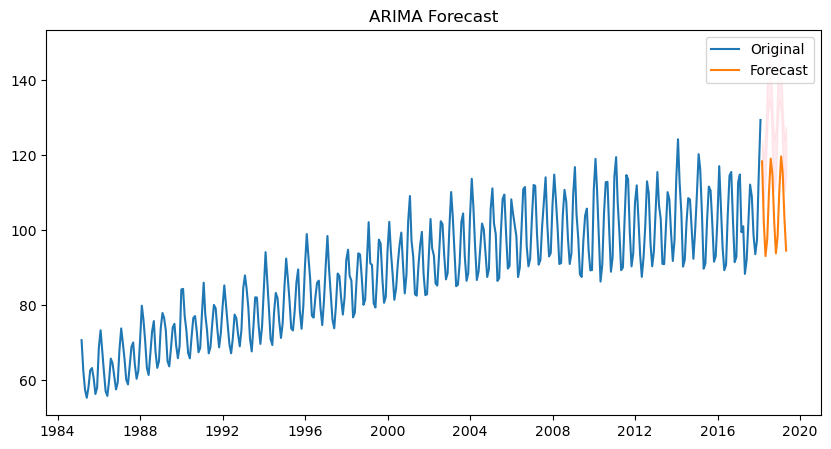

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 4
Q value: 2


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


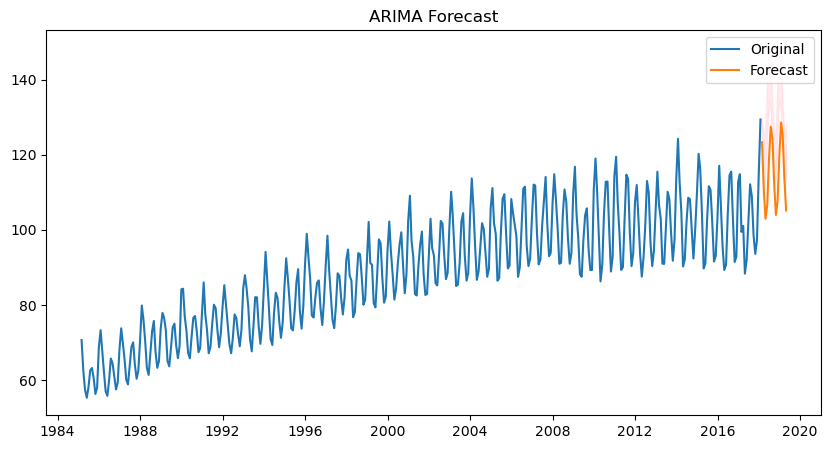

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 4
Q value: 3


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


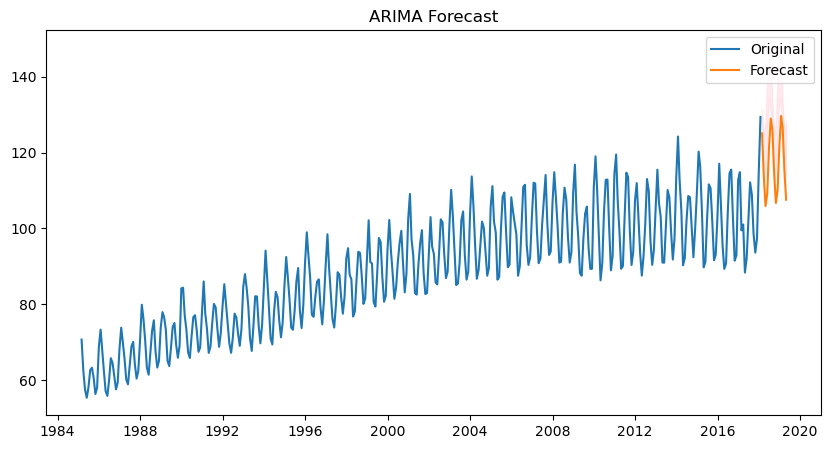

P value: 4
Q value: 4


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


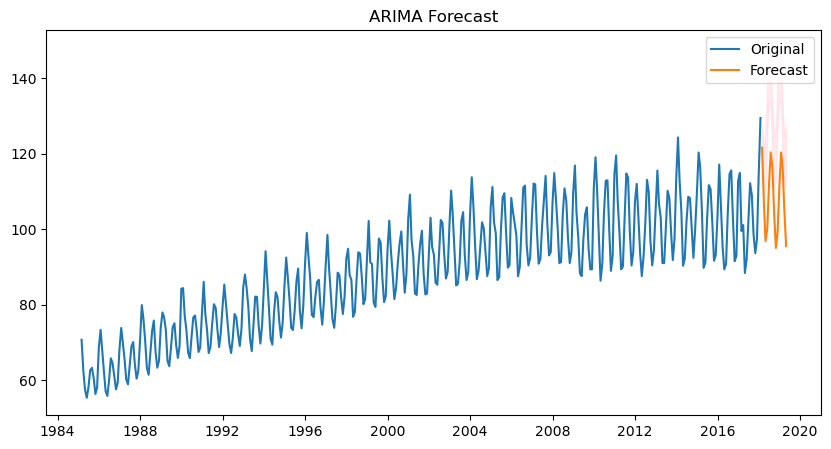

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 4
Q value: 5


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


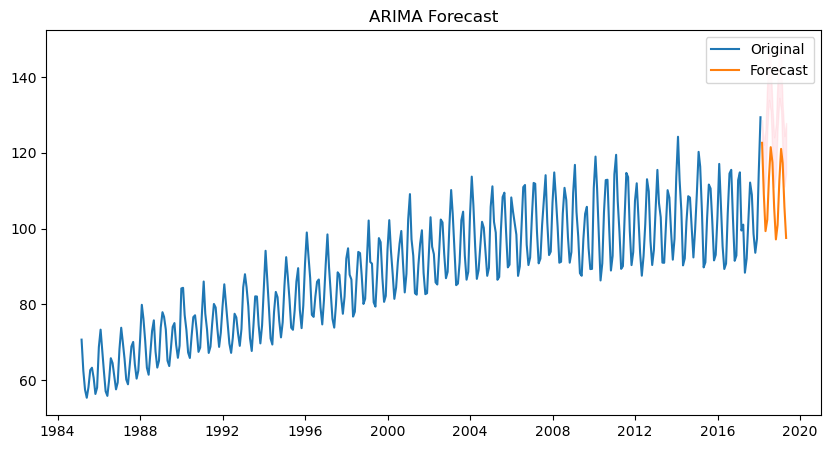

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 5
Q value: 2


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


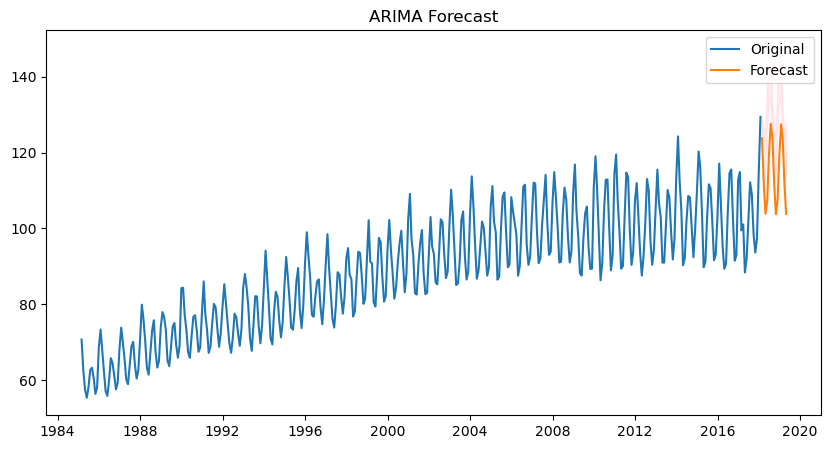

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

P value: 5
Q value: 3


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


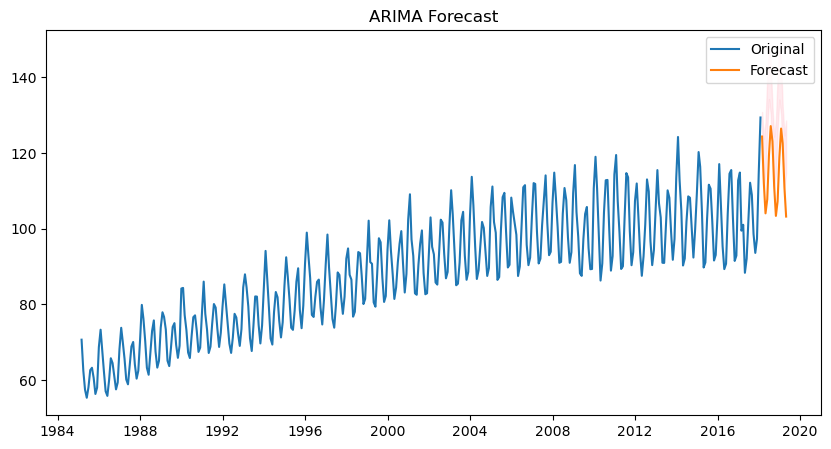

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 5
Q value: 4


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


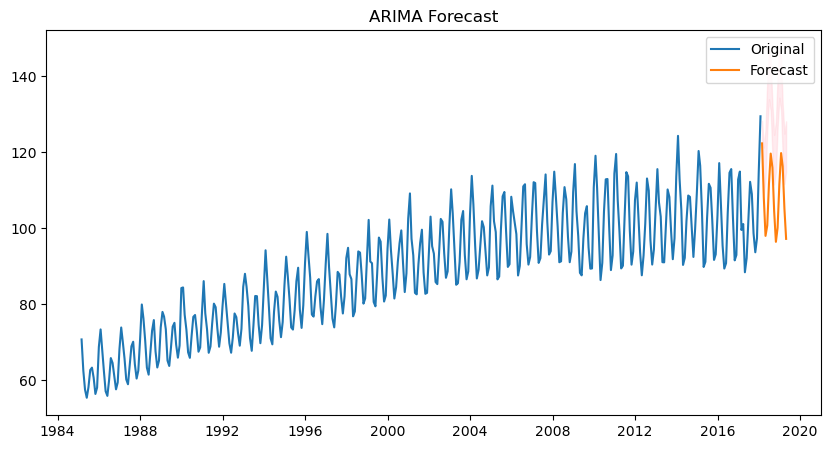

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


P value: 5
Q value: 5


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


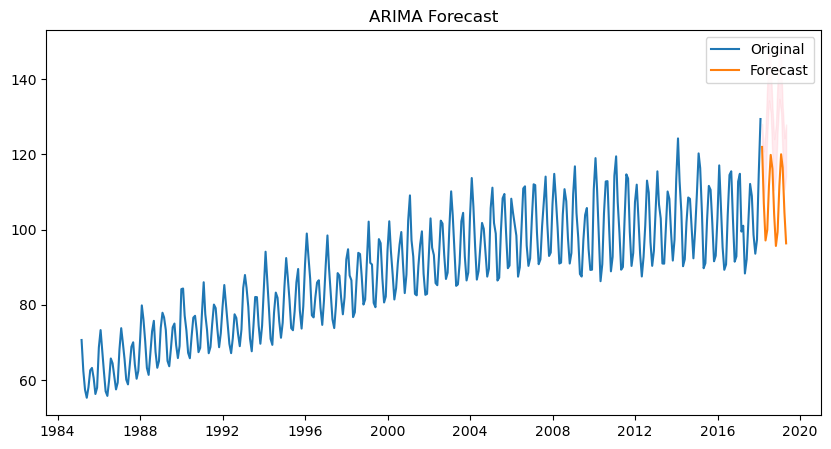

In [30]:
for p_value in p_list:
    for q_value in q_list:
        print("P value:", p_value)
        print("Q value:", q_value)
        model = ARIMA(df['IPG2211A2N_FOD'], order=(p_value, d, q_value))
        fitted_model = model.fit()
        forecast_results = fitted_model.get_forecast(steps=15)
        forecast_values = forecast_results.predicted_mean
        conf_int = forecast_results.conf_int()
        last_value = df['IPG2211A2N'].iloc[-1]
        forecast_levels = np.cumsum(forecast_values) + last_value
        plot_predictions(forecast_levels, conf_int)